In [22]:
from pathlib import Path
from typing import Optional
from omegaconf import DictConfig

import logging
import torch
import matplotlib.pyplot as plt

from tabularbench.core.enums import DatasetSize, ModelName, Task
from tabularbench.core.get_model import get_model
from tabularbench.core.get_trainer import get_trainer

from tabularbench.data.dataset_openml import OpenMLDataset
from tabularbench.results.run_metrics import RunMetrics
from tabularbench.utils.config_run import ConfigRun
from tabularbench.utils.paths_and_filenames import PATH_TO_OPENML_DATASETS
from tabularbench.utils.set_seed import set_seed
from tabularbench.core.run_experiment import run_experiment


cfg = ConfigRun(
    output_dir = "output_run_experiment",
    device = torch.device("cuda:2"),
    model_name = ModelName.FOUNDATION,
    seed = 0,
    task = Task.CLASSIFICATION,
    dataset_size = DatasetSize.MEDIUM,
    datafile_path=Path(PATH_TO_OPENML_DATASETS) / "whytrees_44156_MEDIUM.nc",
    openml_dataset_id = 44156,
    openml_dataset_name = "electricity",
    hyperparams = DictConfig({
        'n_features': 100,
        'n_classes': 10,
        'dim': 512,
        'n_layers': 12,
        'n_heads': 4,
        'attn_dropout': 0.0,
        'y_as_float_embedding': True,
        'linear_attention': False,
        'max_samples_support': 10000,
        'max_samples_query': 10000,
        'max_epochs': 0,
        'optimizer': 'adamw',
        'lr': 1.e-5,
        'weight_decay': 0,
        'lr_scheduler': False,
        'lr_scheduler_patience': 30,
        'early_stopping_patience': 40,
        'use_pretrained_weights': True,
        'n_ensembles': 1,
        'use_quantile_transformer': True,
        'use_feature_count_scaling': True
    })
)

tabpfn_weights = 'tabularbench/models/tabPFN/prior_diff_real_checkpoint_n_0_epoch_42.cpkt'
foundation_forest_weights = 'outputs_done/foundation_forest_big_300k/weights/model_step_300000.pt'
foundation_pfn_weights = 'outputs_done/foundation_tabpfn_big/weights/model_step_500000.pt'
foundation_forest_128_weights = 'outputs_done/foundation_forest_dim_128/weights/model_step_300000.pt'
foundation_forest_256_weights = 'outputs_done/foundation_forest_dim_256/weights/model_step_300000.pt'

In [2]:
import numpy as np

dataset = OpenMLDataset(cfg.datafile_path, cfg.task)
metrics = RunMetrics()

x_train, x_val, x_test, y_train, y_val, y_test, categorical_indicator = next(dataset.split_iterator())

# variables 0 and 3 are the most important ones (as selected by random forest feature importance)
features = [0, 3]

x_train = x_train[:, features]
x_val = x_val[:, features]
x_test = x_test[:, features]

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

coolwarm = plt.get_cmap('coolwarm')
coolwarm_trunc = truncate_colormap(coolwarm, 0.1, 0.9)

In [4]:
def irregularity_value(pred_grid):

    pred = pred_grid[:, :, 0]

    pred_middle = pred[1:-1, 1:-1]
    pred_up = pred[:-2, 1:-1]
    pred_down = pred[2:, 1:-1]
    pred_left = pred[1:-1, :-2]
    pred_right = pred[1:-1, 2:]

    pred_diff = np.abs(pred_middle - pred_up) + np.abs(pred_middle - pred_down) + np.abs(pred_middle - pred_left) + np.abs(pred_middle - pred_right)

    return pred_diff.sum() / pred_diff.size

In [5]:
import einx

x1 = (np.arange(1000) / 100 - 0.5) * 6
x2 = (np.arange(1000) / 100 - 0.5) * 6

x_mesh1, x_mesh2 = np.meshgrid(x1, x2)

x_mesh1_col = einx.rearrange('h w -> (h w)', x_mesh1)
x_mesh2_col = einx.rearrange('h w -> (h w)', x_mesh2)

x_grid = np.zeros((1000000, x_test.shape[1]))
x_grid[:, 0] = x_mesh1_col
x_grid[:, 1] = x_mesh2_col

In [6]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, alpha=1e-4)
mlp.fit(x_train, y_train)
score_test_mlp = mlp.score(x_test, y_test)

score_test_mlp

0.787326911499097

Text(0.5, 1.0, 'MLP (acc: 0.787, irreg: 0.0024)')

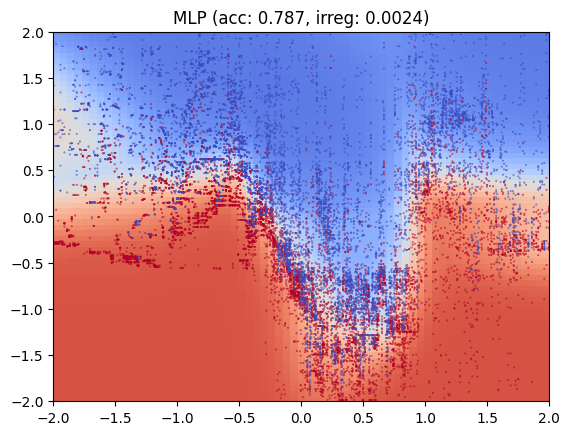

In [7]:
preds = mlp.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

irreg_value = irregularity_value(preds)

plt.pcolormesh(x_mesh1, x_mesh2, preds[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"MLP (acc: {score_test_mlp:.3f}, irreg: {irreg_value:.4f})")

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
score_test_rf = clf.score(x_test, y_test)

score_test_rf


0.8693558097531607

In [9]:
clf.feature_importances_

array([0.41942146, 0.58057854])

Text(0.5, 1.0, 'Random Forest (acc: 0.869, irreg: 0.0126)')

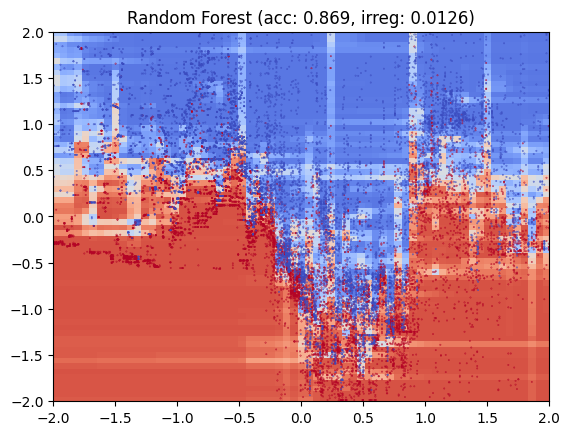

In [10]:
preds = clf.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

irreg_value = irregularity_value(preds)

plt.pcolormesh(x_mesh1, x_mesh2, preds[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title(f"Random Forest (acc: {score_test_rf:.3f}, irreg: {irreg_value:.4f})")

In [20]:
from tabularbench.core.dataset_split import make_dataset_split
from tabularbench.core.run_experiment import Data

def make_boundary_plot(name: str):

    data = Data.from_standard_datasplits(x_train, x_val, x_test, y_train, y_val, y_test, cfg.task)

    model = get_model(cfg, data.x_train_cut, data.y_train_cut, categorical_indicator)
    trainer = get_trainer(cfg, model, dataset.n_classes)
    trainer.train(data.x_train_cut, data.y_train_cut, data.x_val_earlystop, data.y_val_earlystop)
    prediction_metrics_test = trainer.test(data.x_train_and_val, data.y_train_and_val, data.x_test, data.y_test)

    score_test = prediction_metrics_test.score

    preds_pfn_raw = trainer.predict(x_train, y_train, x_grid)
    preds_pfn = einx.softmax('n [c]', preds_pfn_raw)
    preds_pfn = einx.rearrange('(h w) c -> h w c', preds_pfn, w=1000)

    irreg_value = irregularity_value(preds_pfn)

    plt.pcolormesh(x_mesh1, x_mesh2, preds_pfn[:, :, 0], cmap=coolwarm_trunc)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
    plt.ylim(-2, 2)
    plt.xlim(-2, 2)
    plt.title(f"{name} (acc: {score_test:.3f}, irreg: {irreg_value:.4f})")

2024-03-22 10:03:42.919 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4433 | Val score: 0.7840


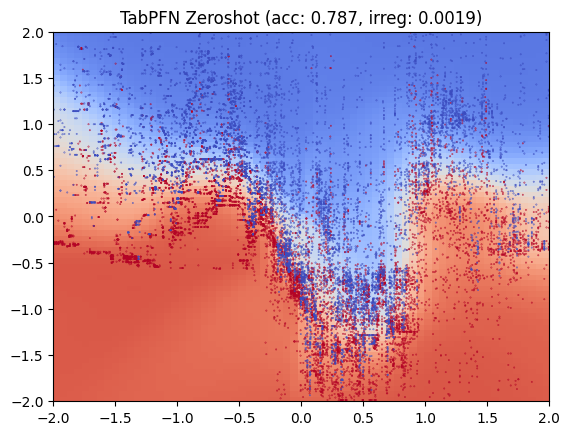

In [23]:
cfg.hyperparams['path_to_weights'] = tabpfn_weights
cfg.hyperparams['max_epochs'] = 0
cfg.hyperparams['dim'] = 512
cfg.model_name = ModelName.TABPFN

make_boundary_plot("TabPFN Zeroshot")

2024-03-22 10:04:43.588 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4574 | Val score: 0.7815
2024-03-22 10:04:44.681 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4296 | Train score: 0.7994 | Val loss: 0.4575 | Val score: 0.7835
2024-03-22 10:04:45.459 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4483 | Train score: 0.7738 | Val loss: 0.4520 | Val score: 0.7860
2024-03-22 10:04:46.562 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4328 | Train score: 0.7863 | Val loss: 0.4534 | Val score: 0.7800
2024-03-22 10:04:47.298 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4421 | Train score: 0.7887 | Val loss: 0.4468 | Val score: 0.7860
2024-03-22 10:04:48.400 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4211 | Train sco

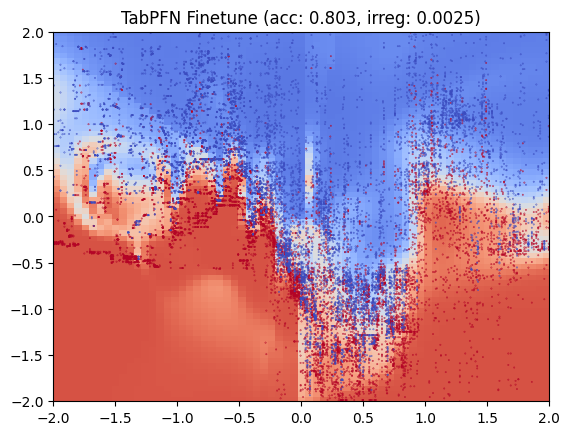

In [24]:
cfg.hyperparams['max_epochs'] = 300

make_boundary_plot("TabPFN Finetune")

2024-03-22 09:45:20.768 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4798 | Val score: 0.7755


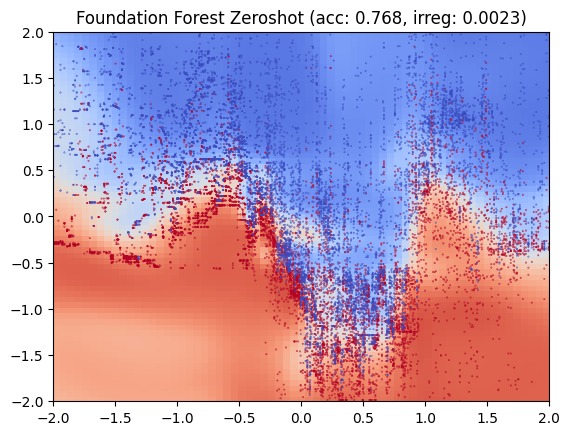

In [14]:
cfg.hyperparams['path_to_weights'] = foundation_forest_weights
cfg.hyperparams['max_epochs'] = 0
cfg.hyperparams['dim'] = 512

make_boundary_plot("Foundation Forest Zeroshot")


2024-03-22 09:46:37.508 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4512 | Val score: 0.7895


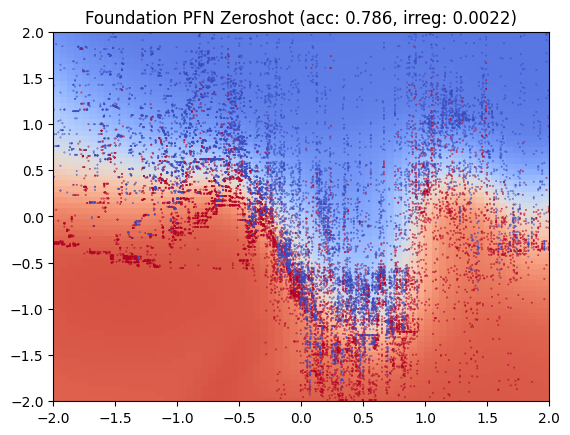

In [15]:
make_boundary_plot(foundation_pfn_weights, "Foundation PFN Zeroshot", epochs = 0)

2024-03-22 09:47:54.831 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4735 | Val score: 0.7730
2024-03-22 09:47:56.356 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4643 | Train score: 0.7756 | Val loss: 0.4536 | Val score: 0.7750
2024-03-22 09:47:57.792 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4352 | Train score: 0.7756 | Val loss: 0.4365 | Val score: 0.7845
2024-03-22 09:47:59.185 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4472 | Train score: 0.7906 | Val loss: 0.4344 | Val score: 0.7845
2024-03-22 09:48:00.586 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4348 | Train score: 0.7863 | Val loss: 0.4281 | Val score: 0.8000
2024-03-22 09:48:02.031 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4316 | Train sco

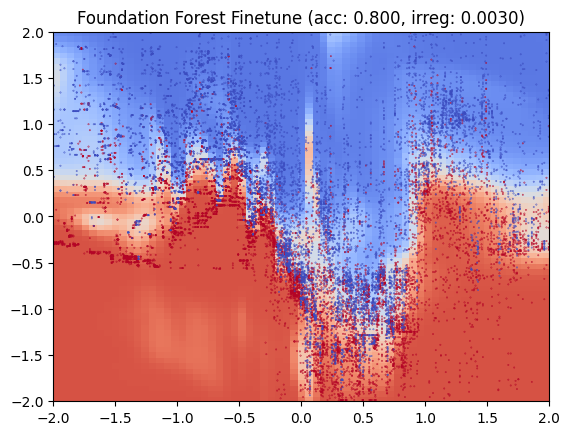

In [16]:
make_boundary_plot(foundation_forest_weights, "Foundation Forest Finetune", epochs = 300)

2024-03-22 09:51:31.947 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4673 | Val score: 0.7880
2024-03-22 09:51:33.354 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4422 | Train score: 0.7856 | Val loss: 0.4616 | Val score: 0.7820
2024-03-22 09:51:34.768 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4430 | Train score: 0.7937 | Val loss: 0.4723 | Val score: 0.7855
2024-03-22 09:51:35.637 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4460 | Train score: 0.7881 | Val loss: 0.4577 | Val score: 0.7855
2024-03-22 09:51:37.069 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4403 | Train score: 0.7894 | Val loss: 0.4546 | Val score: 0.7830
2024-03-22 09:51:38.522 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4287 | Train sco

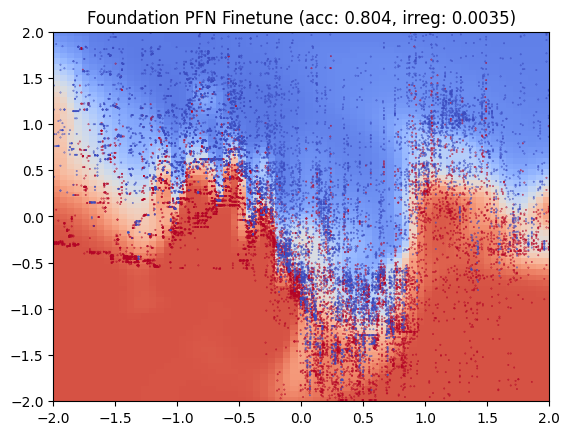

In [17]:
make_boundary_plot(foundation_pfn_weights, "Foundation PFN Finetune", epochs = 300)

2024-03-22 09:55:29.184 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4462 | Val score: 0.7940
2024-03-22 09:55:29.852 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4574 | Train score: 0.7837 | Val loss: 0.4377 | Val score: 0.7815
2024-03-22 09:55:30.527 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4343 | Train score: 0.7863 | Val loss: 0.4342 | Val score: 0.7885
2024-03-22 09:55:31.192 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4412 | Train score: 0.7831 | Val loss: 0.4336 | Val score: 0.7910
2024-03-22 09:55:31.861 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4468 | Train score: 0.7856 | Val loss: 0.4317 | Val score: 0.7885
2024-03-22 09:55:32.527 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4522 | Train sco

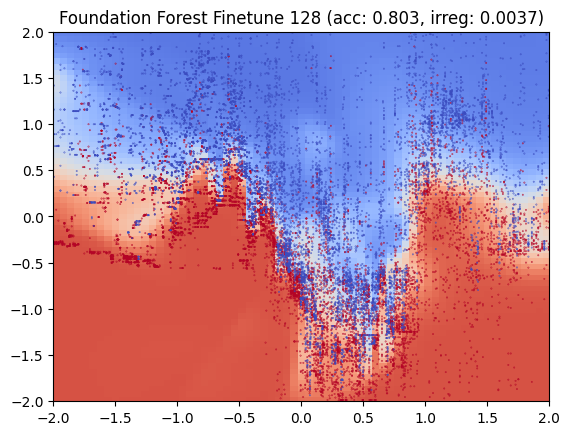

In [18]:
make_boundary_plot(foundation_forest_128_weights, "Foundation Forest Finetune 128", epochs = 300, dim=128)

2024-03-22 09:59:39.702 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4538 | Val score: 0.7710
2024-03-22 09:59:40.536 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4769 | Train score: 0.7550 | Val loss: 0.4353 | Val score: 0.7980
2024-03-22 09:59:41.366 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4285 | Train score: 0.8044 | Val loss: 0.4336 | Val score: 0.7910
2024-03-22 09:59:42.189 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4449 | Train score: 0.7831 | Val loss: 0.4340 | Val score: 0.7945
2024-03-22 09:59:42.868 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4281 | Train score: 0.7956 | Val loss: 0.4323 | Val score: 0.7985
2024-03-22 09:59:43.683 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4187 | Train sco

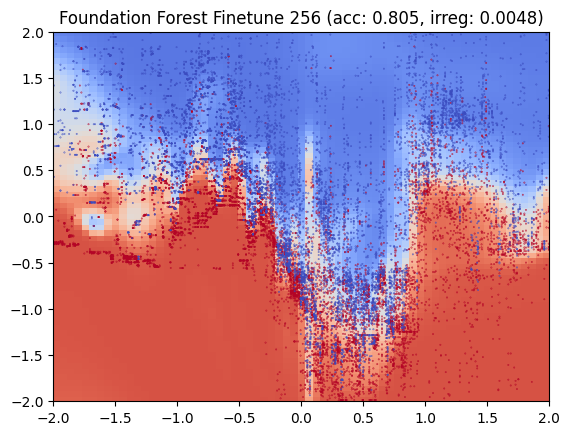

In [19]:
make_boundary_plot(foundation_forest_256_weights, "Foundation Forest Finetune 256", epochs = 300, dim=256)